In [4]:
import numpy as np
from PIL import Image
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

In [5]:
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [6]:
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

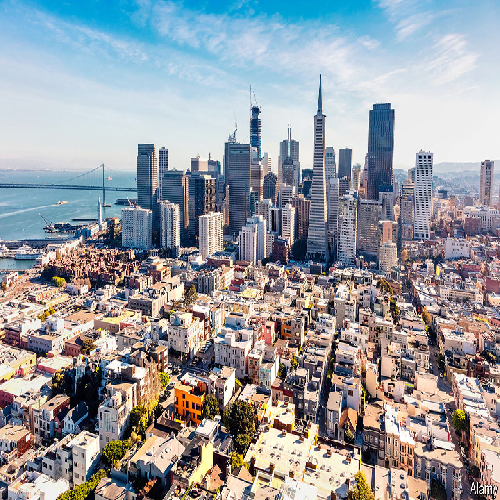

In [8]:
input_image = Image.open(input_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image

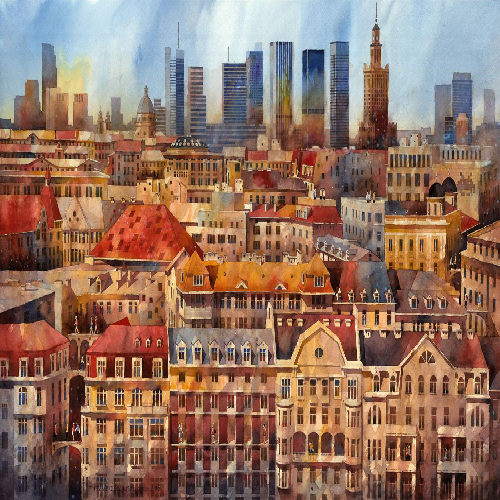

In [9]:
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image

In [10]:
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [12]:
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [13]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [15]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_2': <tf.Tensor 'concat_1:0' shape=(3, 500, 500, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 500, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 500, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 250, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 250, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 250, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 125, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 62, 62, 256) dtype=float32

In [22]:
content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [27]:
loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

In [31]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [33]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss

In [35]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [38]:
outputs = [loss]
outputs = outputs + backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()


Iteration 0 completed with loss 146201280512
Iteration 1 completed with loss 70781714432
Iteration 2 completed with loss 49327726592
Iteration 3 completed with loss 39395139584
Iteration 4 completed with loss 35432939520
Iteration 5 completed with loss 33299818496
Iteration 6 completed with loss 31685804032
Iteration 7 completed with loss 30666762240
Iteration 8 completed with loss 29992486912
Iteration 9 completed with loss 29495179264


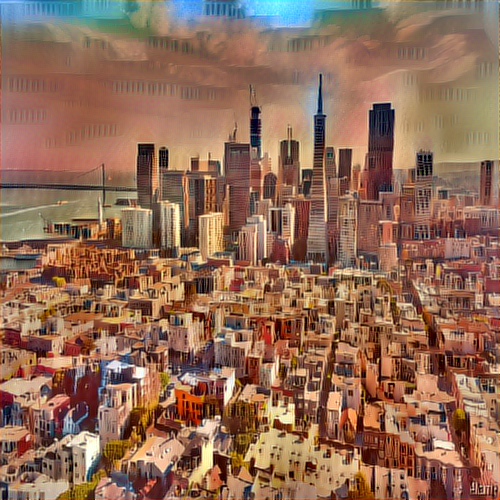

In [41]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

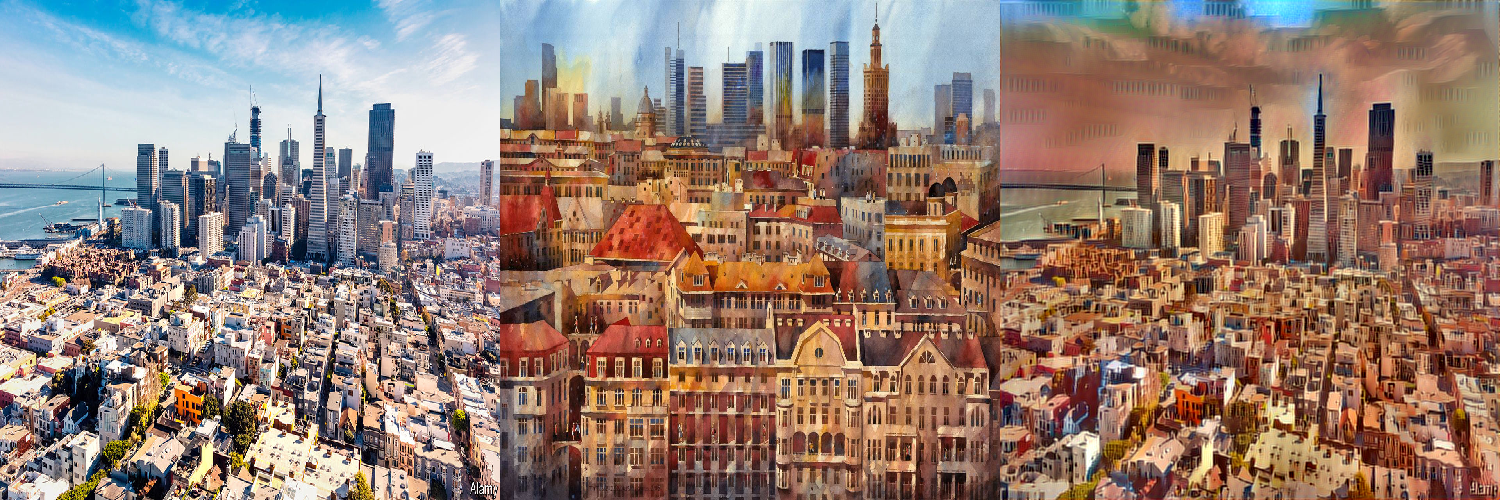

In [42]:
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined